In [100]:
import math
import matplotlib.pyplot as plt
import numpy as np

In [101]:
def f(x):
  return 5*x**2 - 5


In [ ]:
xs = np.arange(-5,5,0.25)

In [ ]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys =f(xs)

In [ ]:
ys

array([120.    , 107.8125,  96.25  ,  85.3125,  75.    ,  65.3125,
        56.25  ,  47.8125,  40.    ,  32.8125,  26.25  ,  20.3125,
        15.    ,  10.3125,   6.25  ,   2.8125,   0.    ,  -2.1875,
        -3.75  ,  -4.6875,  -5.    ,  -4.6875,  -3.75  ,  -2.1875,
         0.    ,   2.8125,   6.25  ,  10.3125,  15.    ,  20.3125,
        26.25  ,  32.8125,  40.    ,  47.8125,  56.25  ,  65.3125,
        75.    ,  85.3125,  96.25  , 107.8125])

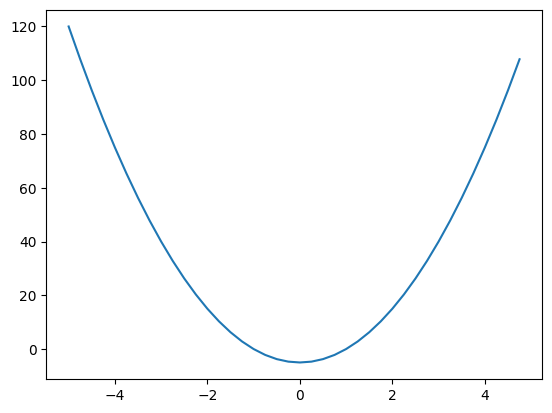

In [ ]:
plt.plot(xs,ys)

In [ ]:
h = 0.000000000000001
x = -3.0
(f(x+h) - f(x))/h

-28.421709430404004

In [ ]:
h= 0.00001
a = 2
b = -3
c = 10.0


d1 = a*b + c
c+=h
d2 = a*b + c

m = (d2-d1)/h

d1,d2,m


(4.0, 4.00001, 0.9999999999621422)

In [144]:
class Value:
  def __init__(self, data , _children=(), _op='', label='') -> None:
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"



  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad =1.0
    for node in reversed(topo):
      node._backward()


  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data * other.data , {self, other}, '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t= (math.exp(2*x) - 1)/(math.exp(2*x)+ 1)
    out = Value(t, (self, ), 'tanh')


    def _backward():
      self.grad = (1- t**2) * out.grad
    out._backward = _backward



    return out


  def __rmul__(self, other):
    return self * other


  def __radd__(self, other):
    return self + other


  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
      out._backward = _backward

    return out




In [145]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


Value(data=-8.0)

In [103]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

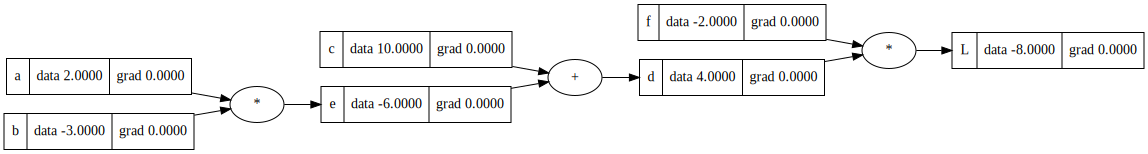

In [ ]:
draw_dot(L)

In [104]:
def lol():

  h=0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data


  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

In [ ]:
lol()

6.000000000021544


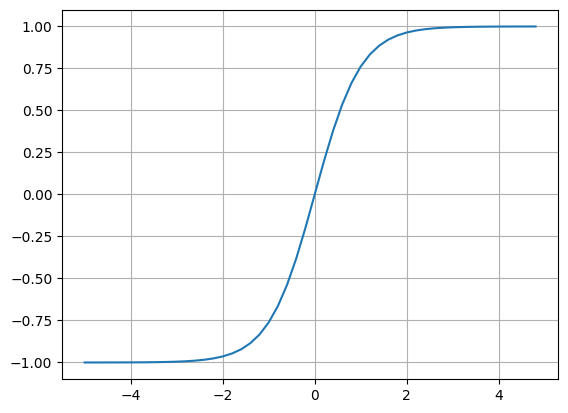

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Value(data=0.7071067811865476)


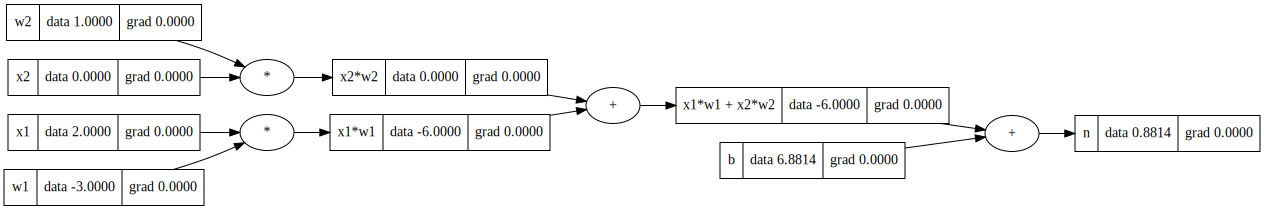

In [140]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o';
print(o)
draw_dot(n)

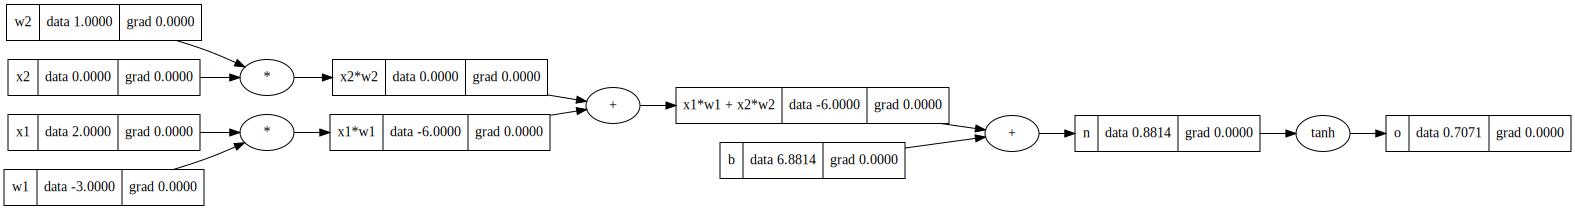

In [141]:
draw_dot(o)

In [ ]:
o.grad = 1.0

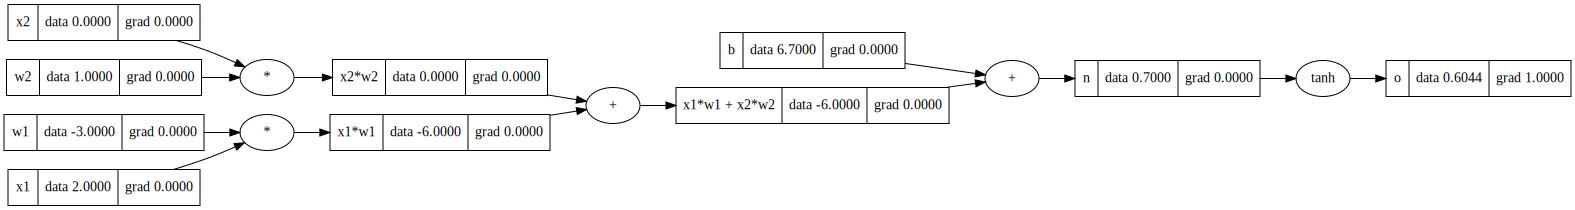

In [ ]:
draw_dot(o)

In [ ]:
'''
o = tanh(n)
do/dn = 1 - o**2
'''

'\no = tanh(n)\ndo/dn = 1 - o**2\n'

In [ ]:
1 - o.data**2

0.4999999999999999

In [ ]:
n.grad = 0.5

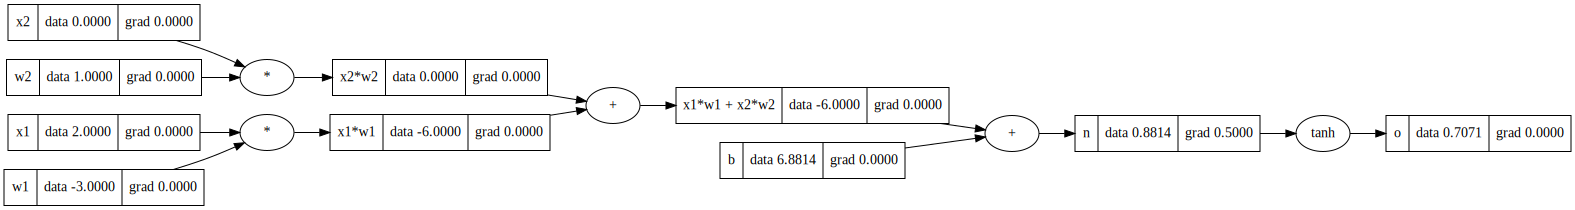

In [ ]:
draw_dot(o)

In [84]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

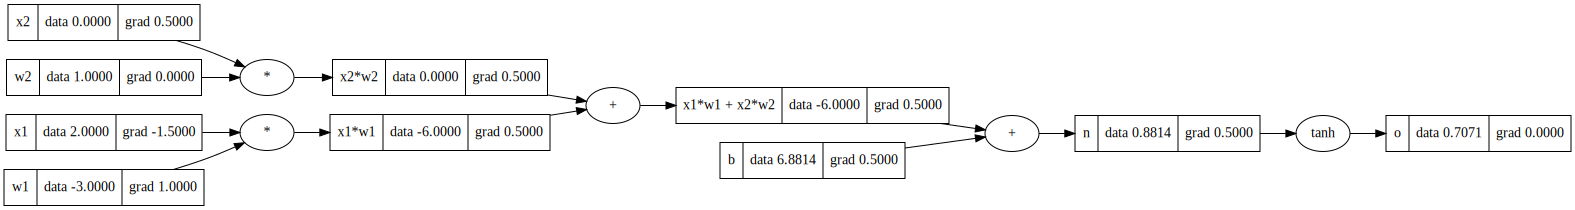

In [87]:
draw_dot(o)

In [86]:

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad



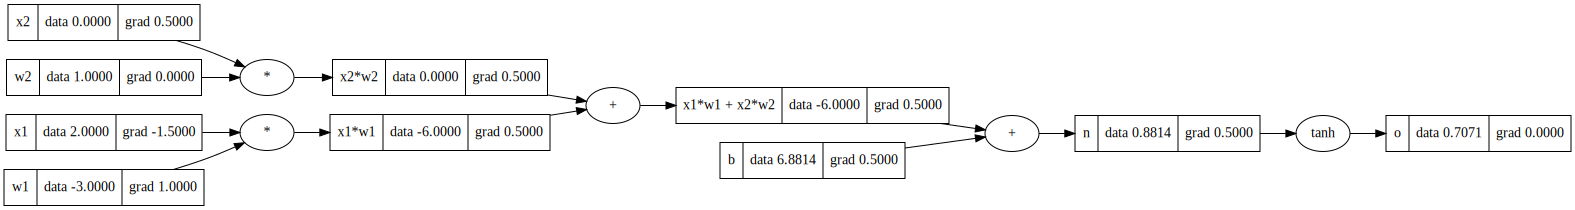

In [88]:
draw_dot(o)

In [ ]:
###after

In [125]:
o.grad = 1.0
o._backward()

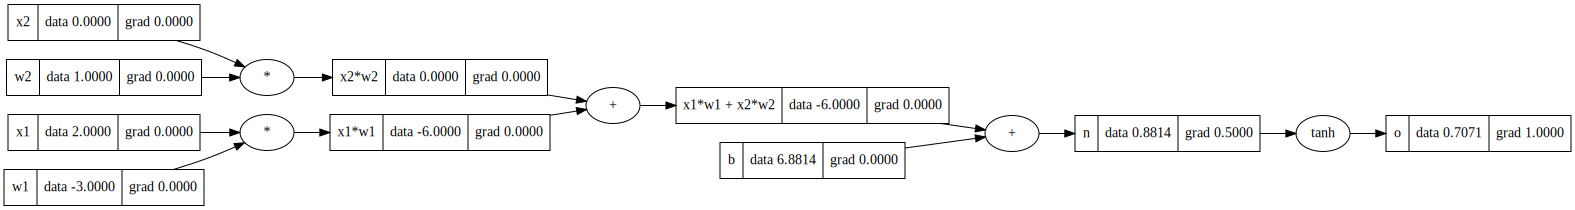

In [126]:
draw_dot(o)

In [127]:
n._backward()

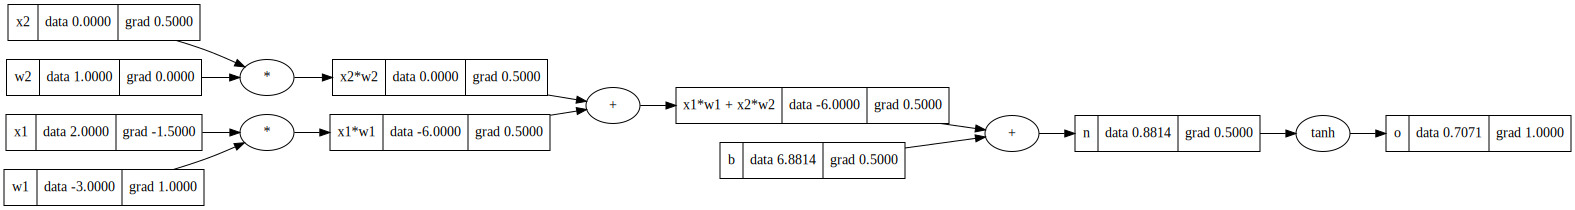

In [134]:
draw_dot(o)

In [129]:
b._backward()

In [131]:
x1w1x2w2._backward()

In [133]:
x2w2._backward()
x1w1._backward()

In [142]:
o.backward()

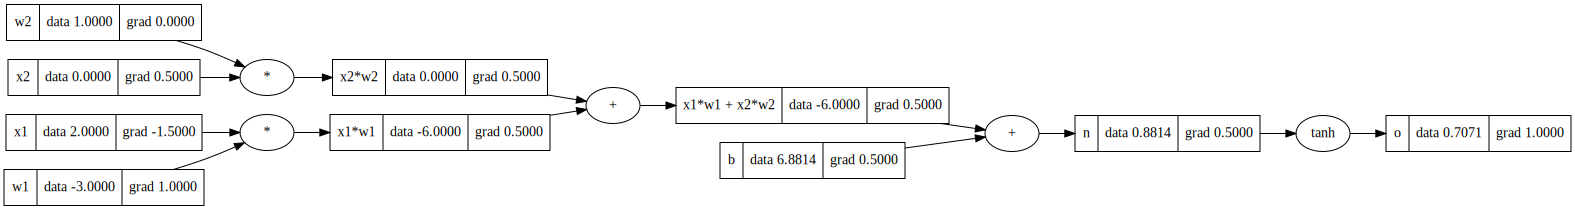

In [143]:
draw_dot(o)

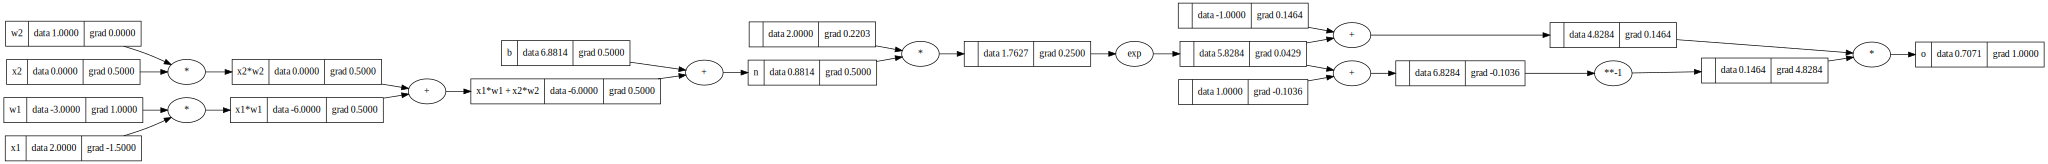

In [146]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)



In [147]:
import torch

In [148]:


x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [149]:
import random

In [174]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))


  def __call__(self, x):

    act = sum( wi*xi for wi,xi in zip(self.w, x)) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]




In [163]:
  x = [2.0, 3.0]
  n = Neuron(2)
  n(x)

Value(data=0.9308208116633347)

In [175]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs


  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [161]:
  x = [2.0, 3.0]
  n = Layer(2,3)
  n(x)

[Value(data=0.5587311562275856),
 Value(data=0.8090911997472827),
 Value(data=-0.7451029195648341)]

In [162]:

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [176]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.908390236480594)

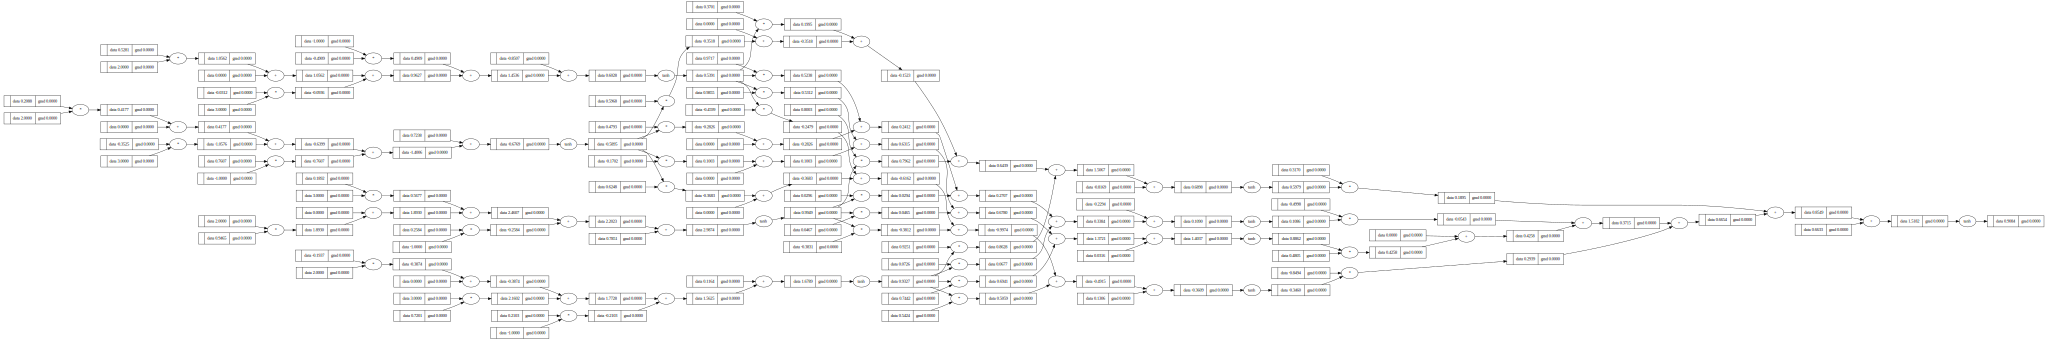

In [177]:
draw_dot(n(x))

In [178]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [179]:

ypred = [n(x) for x in xs]
ypred

[Value(data=0.908390236480594),
 Value(data=0.4762348361506876),
 Value(data=0.2942546790792811),
 Value(data=0.831035709971675)]

In [180]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.891305745860318)

In [187]:
n.layers[0].neurons[0].w[0].grad

-0.25130331966598923

In [182]:
loss.backward()

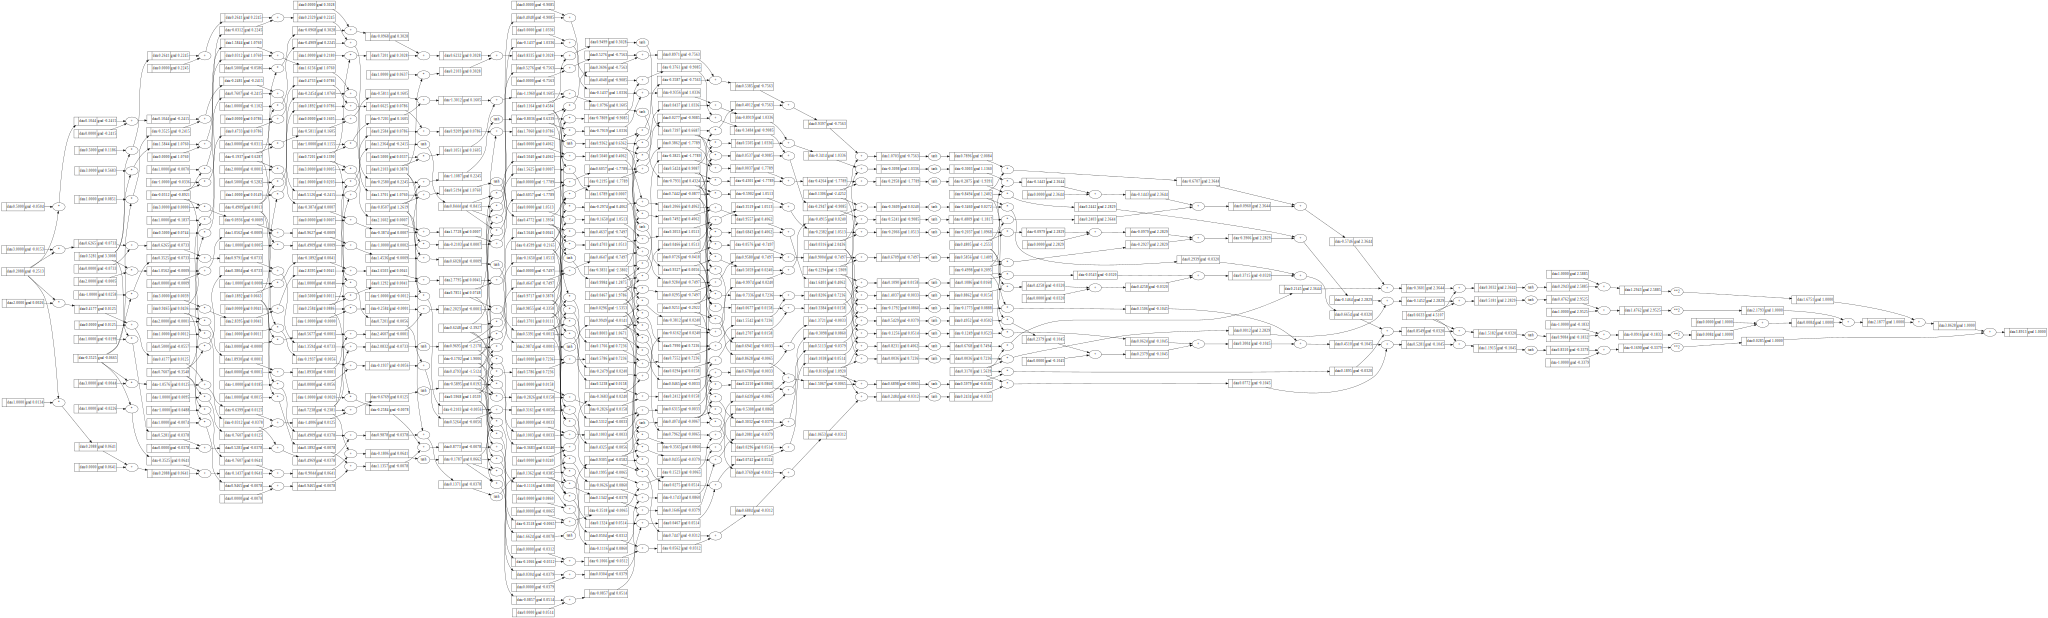

In [184]:
draw_dot(loss)

In [185]:
n.parameters()

[Value(data=0.20883880113297537),
 Value(data=-0.3525389979980822),
 Value(data=0.7607074313587809),
 Value(data=0.7237772230766086),
 Value(data=0.5281247802492661),
 Value(data=-0.031186380293145355),
 Value(data=-0.4908683076103171),
 Value(data=-0.8507382082186261),
 Value(data=0.9465076017152423),
 Value(data=0.18922460375580274),
 Value(data=0.2584279854450926),
 Value(data=0.7851194323301847),
 Value(data=-0.1936997116900323),
 Value(data=0.7200612199108596),
 Value(data=0.21028611533875474),
 Value(data=0.11640876864845984),
 Value(data=-0.17019051912494243),
 Value(data=0.9854678271171673),
 Value(data=0.04670758493380256),
 Value(data=0.7441669505134043),
 Value(data=0.031594824866356674),
 Value(data=0.4793369071316389),
 Value(data=0.9716765977132147),
 Value(data=0.029593425745760404),
 Value(data=0.0726272309946594),
 Value(data=-0.22943072584827795),
 Value(data=0.6247907081710595),
 Value(data=-0.4598653199834346),
 Value(data=-0.3831353149440446),
 Value(data=0.5423744

In [186]:
for p in n.parameters():
  p.data += -0.1 * p.grad

In [238]:


for k in range(500):

  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)




0 0.0005588940376026405
1 0.0005587784890946597
2 0.0005586629871589889
3 0.0005585475317677427
4 0.0005584321228930499
5 0.0005583167605070899
6 0.0005582014445820271
7 0.0005580861750900782
8 0.0005579709520034593
9 0.0005578557752944206
10 0.0005577406449352352
11 0.0005576255608981916
12 0.0005575105231556098
13 0.0005573955316798257
14 0.0005572805864431974
15 0.0005571656874180943
16 0.000557050834576923
17 0.0005569360278921095
18 0.0005568212673361106
19 0.000556706552881372
20 0.0005565918845003954
21 0.0005564772621656899
22 0.0005563626858497927
23 0.000556248155525242
24 0.0005561336711646279
25 0.0005560192327405507
26 0.0005559048402256233
27 0.0005557904935924846
28 0.0005556761928137972
29 0.0005555619378622488
30 0.0005554477287105471
31 0.0005553335653314227
32 0.000555219447697611
33 0.0005551053757818938
34 0.0005549913495570612
35 0.0005548773689959257
36 0.000554763434071326
37 0.0005546495447561118
38 0.0005545357010231624
39 0.0005544219028453707
40 0.0005543081

In [239]:
ypred

[Value(data=0.9916735903349466),
 Value(data=-0.9913783572893001),
 Value(data=-0.9858431042940867),
 Value(data=0.9872555906137044)]